### This is a take at making autoencoder form what is in the internet and comparing with our autencoder to determine where we did wrong.

In [207]:
# import necessary library and modules
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [208]:
# Set up GPU for training....
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [209]:
# Set up data and dataloader
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./',
                            train=True,
                            transform=transform,
                            download=True)

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=64,
                              shuffle=True)

In [210]:
# Check the range of the data [which is (0 to 1)]
image, label = train_data[0]

torch.min(image), torch.max(image)

(tensor(0.), tensor(1.))

In [211]:
# Define the Linear AutoEncoder Model class
class AutoEncoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [212]:
# Define the CNN AutoEncoder Model class
class AutoEncoder_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 1) # -> N, 64, 1, 1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # -> N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [213]:
# Initalize the linear autoencoder  
linear_model = AutoEncoder_Linear().to(device)

# Initalize the cnn autoencoder
cnn_model = AutoEncoder_CNN().to(device)

In [214]:
# Initalize the loss and optimizer for training model

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(linear_model.parameters(),
                             lr=0.001)

In [ ]:
# Initalize the flatten model to flatten the image because our linear model takes as input only the linear shaped tensor
flatten = nn.Flatten()

In [ ]:
# Check the shape of data as it inputs and outputs (flows through) the model
flattened_tensor = flatten(train_data[0][0]).to(device)
print(f'The flattend tensor shape inputted into model: {flattened_tensor.shape}')
output = linear_model(flattened_tensor)
print(f'The encoded shape of the data: {output[0].shape}')
print(f'The decoded shape of the data: {output[1].shape}')

The flattend tensor shape inputted into model: torch.Size([1, 784])
The encoded shape of the data: torch.Size([1, 3])
The decoded shape of the data: torch.Size([1, 784])


In [ ]:
# Train our model
num_epochs = 10

for epoch in range(num_epochs):
    linear_model.train()

    for index, (image, label)in enumerate(train_dataloader):
        image = image.to(device)

        flat_image = flatten(image)
        
        output = linear_model(flat_image)

        loss = criterion(output[1], flat_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epcoh: {epoch+1} | Loss: {loss}')

Epcoh: 1 | Loss: 0.03560682013630867
Epcoh: 2 | Loss: 0.02971450425684452
Epcoh: 3 | Loss: 0.030605418607592583
Epcoh: 4 | Loss: 0.03439583629369736
Epcoh: 5 | Loss: 0.029075412079691887
Epcoh: 6 | Loss: 0.032823435962200165
Epcoh: 7 | Loss: 0.03301337733864784
Epcoh: 8 | Loss: 0.033289216458797455
Epcoh: 9 | Loss: 0.03001580946147442
Epcoh: 10 | Loss: 0.027948729693889618


Text(0.5, 1.0, 'Encoded Data Output')

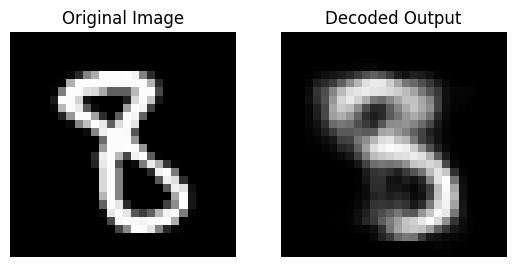

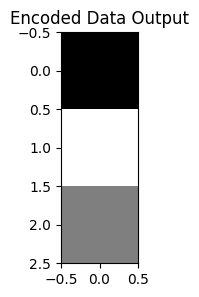

In [354]:
# Visualize the original data/image, encoded output and the decodeded output of the trained model
import random

# picks a random image from our test data and flattens it (making it ready to pass into our linear model)
rand_int = random.choice(range(len(train_data)))
image = train_data[rand_int][0]
flat_image = flatten(image)

# pass the flattend data into the model
model_output = linear_model(flat_image.to(device))

# get the encoded output data and reshape it to plot in graph/image
model_encoded_output = model_output[0]
encoded_output_reshaped = model_encoded_output.reshape(1, -1, 1).detach().cpu()

# get the decode output data and reshape it to plot in graph/image 
model_decoded_output = model_output[1]
decoded_output_reshaped = model_decoded_output.reshape(-1, 28, 28).detach().cpu()

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0), cmap='grey')
plt.title('Original Image')
plt.axis(False)

# plot the decode image
plt.subplot(1, 2, 2)
plt.imshow(decoded_output_reshaped.permute(1, 2, 0), cmap='grey')
plt.title('Decoded Output')
plt.axis(False)

# plot the encoded latent representation
plt.figure(figsize=(3, 3))
plt.imshow(encoded_output_reshaped.permute(1, 2, 0), cmap='grey')
plt.title('Encoded Data Output')

In [364]:
with torch.inference_mode():

    linear_model.eval()

    output = []
    for image, label in train_dataloader:
        image = image.to(device)

        flat_image = flatten(image)
        
        encoded_output = linear_model(flat_image)[0]
        output.append(encoded_output)
        


In [362]:
output

[tensor([[  5.5224, -14.3712,  -8.4271],
         [  4.9367,   2.2919,   1.7836],
         [  9.1533,  -3.7050,   5.5005],
         [  6.4729,   2.5230,   0.8127],
         [  4.0433,   2.7390,  -3.2757],
         [  0.4676,   6.3577,  -0.2189],
         [  3.6942,   3.3706,  -0.0535],
         [  7.0241,   7.4805,   3.0156],
         [ 16.2412,  -1.7945,  -1.1459],
         [  8.1865,   0.7920,   1.4042],
         [  0.3041,   0.4470,   0.8326],
         [  4.8582,   2.0628,   4.7110],
         [  4.2071,   3.4026,  -1.7328],
         [ 11.9127,  -1.3093,  -4.7170],
         [  2.5292,   5.6741,   0.4372],
         [  8.6709,   3.0192,  -1.5232],
         [  6.8069,   0.8834,  -8.0517],
         [ 14.9648,   0.2199,   2.7618],
         [ 20.7548,   7.6107,  -7.8312],
         [  5.7792,  -2.5438,   0.5284],
         [  5.9723,   2.4823,   8.5531],
         [ 15.6263,   3.3083, -12.0024],
         [  7.7708,   1.0305,  -4.6602],
         [ 19.3438,  -2.8211,  -5.4549],
         [ 18.14